## Preparation

In [1]:
data_path = "data/DataChallenge_GBDentalClaims.xlsx"
target_column = 'sum_paid_amt_after_cob'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats.mstats import winsorize

In [4]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.model_selection import RandomizedSearchCV

In [5]:
import xgboost as xgb

## Pull data and variables

In [6]:
metadata = pd.read_excel(data_path, sheet_name='data_summary')
amt_category = 'Dental Claim usage during the most recent benefit year'
current_year_variables = metadata[metadata["Feature Category"] == amt_category]["Feature"].values

In [7]:
data = pd.read_excel(data_path, sheet_name='dataset') 
data = data.set_index('ee_id')
data.head()

,policy number,member_id,language,gender,pol_renewal_dt,days_exposure_dental,num_claims,total_num_serv_lines,sum_charge_amt,sum_paid_amt,...,ftr_env_pct_household_2person,ftr_env_pct_household_3person,ftr_env_pct_household_4person,ftr_env_pct_household_5person,pol_renewal_yr,ftr_years_since_cert_effective,ftr_age_at_renewal,MARKET_SEGMENT_ADJ,industry,province
ee_id,,,,,,,,,,,,,,,,,,,,,
3433_3433,3433,3433,E,M,2018-06-01,365,NaN,NaN,NaN,NaN,...,0.272997,0.181009,0.148368,0.183976,2018,1.750685,50.750685,SUNADVANTAGE,retail_trade,ontario
3433_38,3433,38,E,M,2017-06-01,365,NaN,NaN,NaN,NaN,...,0.483271,0.111524,0.083643,0.029740,2017,5.254795,54.613699,SUNADVANTAGE,retail_trade,ontario
3447_8,3447,8,E,F,2019-06-01,366,5.0,16.0,1366.0,1052.8,...,0.327586,0.068966,0.034483,0.000000,2019,11.257534,51.739726,SUNADVANTAGE,service_repair_business,ontario
3473_9,3473,9,E,M,2017-06-01,365,NaN,NaN,NaN,NaN,...,0.314815,0.055556,0.018519,0.000000,2017,9.257534,45.279452,SUNSOLUTIONS,service_repair_business,saskatchewan
3498_1073,3498,1073,E,M,2019-07-01,366,2.0,8.0,402.0,301.6,...,0.434783,0.130435,0.173913,0.043478,2019,0.246575,47.646575,SUNADVANTAGE,manufacturing,ontario


In [8]:
current_charges = [
'sum_paid_amt_after_cob',
'sum_charge_amt',
'sum_paid_amt',
'sum_adj_amt',
'sum_paid_amt_cldld',
'sum_lab_chrg_amt',
'sum_charge_amt_dep',
'sum_paid_amt_dep',
'sum_adj_amt_dep',
'sum_paid_amt_cldld_dep',
'sum_paid_amt_after_cob_dep',
'sum_dent_chrg_amt_dep',
'sum_lab_chrg_amt_dep',
]

### Keep or Drop?

In [9]:
data[current_charges].corr()

,sum_paid_amt_after_cob,sum_charge_amt,sum_paid_amt,sum_adj_amt,sum_paid_amt_cldld,sum_lab_chrg_amt,sum_charge_amt_dep,sum_paid_amt_dep,sum_adj_amt_dep,sum_paid_amt_cldld_dep,sum_paid_amt_after_cob_dep,sum_dent_chrg_amt_dep,sum_lab_chrg_amt_dep
sum_paid_amt_after_cob,1.000000,0.775395,1.000000,0.993512,0.972304,0.259050,0.683008,0.844418,0.841352,0.812865,0.844418,0.697625,0.210762
sum_charge_amt,0.775395,1.000000,0.775395,0.766126,0.803758,0.600624,0.792704,0.647908,0.644282,0.685298,0.647908,0.785331,0.409755
sum_paid_amt,1.000000,0.775395,1.000000,0.993512,0.972304,0.259050,0.683008,0.844418,0.841352,0.812865,0.844418,0.697625,0.210762
sum_adj_amt,0.993512,0.766126,0.993512,1.000000,0.966345,0.249129,0.678035,0.839427,0.845244,0.808496,0.839427,0.692279,0.211029
sum_paid_amt_cldld,0.972304,0.803758,0.972304,0.966345,1.000000,0.265654,0.732191,0.825289,0.822375,0.861646,0.825289,0.747494,0.228421
sum_lab_chrg_amt,0.259050,0.600624,0.259050,0.249129,0.265654,1.000000,0.327665,0.150139,0.151009,0.164020,0.150139,0.253121,0.654535
sum_charge_amt_dep,0.683008,0.792704,0.683008,0.678035,0.732191,0.327665,1.000000,0.811444,0.805331,0.857083,0.811444,0.991918,0.508636
sum_paid_amt_dep,0.844418,0.647908,0.844418,0.839427,0.825289,0.150139,0.811444,1.000000,0.994373,0.957285,1.000000,0.830709,0.237500
sum_adj_amt_dep,0.841352,0.644282,0.841352,0.845244,0.822375,0.151009,0.805331,0.994373,1.000000,0.952059,0.994373,0.824180,0.237552
sum_paid_amt_cldld_dep,0.812865,0.685298,0.812865,0.808496,0.861646,0.164020,0.857083,0.957285,0.952059,1.000000,0.957285,0.876717,0.255707


In [10]:
id_columns = ['policy number','member_id']
current_charges.remove(target_column)
data = data.drop(columns=id_columns)
data = data.drop(columns=current_charges)

## Feature Types

In [11]:
numerical_data = data.select_dtypes(include=np.number).copy()
numerical_data.head()

,days_exposure_dental,num_claims,total_num_serv_lines,sum_paid_amt_after_cob,num_claims_dep,total_num_serv_lines_dep,num_claims_exam,num_claims_scaling,num_claims_crowns,num_claims_restorations,...,ftr_env_avg_household_income,ftr_env_med_household_income,ftr_env_pct_household_1person,ftr_env_pct_household_2person,ftr_env_pct_household_3person,ftr_env_pct_household_4person,ftr_env_pct_household_5person,pol_renewal_yr,ftr_years_since_cert_effective,ftr_age_at_renewal
ee_id,,,,,,,,,,,,,,,,,,,,,
3433_3433,365,NaN,NaN,0.0,NaN,NaN,0,0,0,0,...,98299.48,98645.96,0.213650,0.272997,0.181009,0.148368,0.183976,2018,1.750685,50.750685
3433_38,365,NaN,NaN,0.0,NaN,NaN,0,0,0,0,...,96600.43,85154.40,0.291822,0.483271,0.111524,0.083643,0.029740,2017,5.254795,54.613699
3447_8,366,5.0,16.0,1052.8,4.0,13.0,0,1,0,1,...,121483.06,94643.76,0.568966,0.327586,0.068966,0.034483,0.000000,2019,11.257534,51.739726
3473_9,365,NaN,NaN,0.0,NaN,NaN,0,0,0,0,...,63517.52,60000.00,0.611111,0.314815,0.055556,0.018519,0.000000,2017,9.257534,45.279452
3498_1073,366,2.0,8.0,301.6,1.0,4.0,0,0,0,0,...,89307.86,63042.30,0.217391,0.434783,0.130435,0.173913,0.043478,2019,0.246575,47.646575


In [12]:
# for col in numerical_data.columns:
#     if sum(numerical_data[col].isnull())>0:
#         print(f"{col}: {sum(numerical_data[col].isnull())}")

In [13]:
null_if_null_list = [
    'ftr_employee_age_as_of_renewal',
    'ftr_employee_spouse_age_as_of_renewal',
    'ftr_employee_daughter_age_as_of_renewal',
    'ftr_employee_spouse_dependent_flag',
    'ftr_employee_children_dependent_flag',
    'ftr_employee_student_presence_flag',
    'ftr_employee_handicap_presence_flag',
    'ftr_employee_male_presence_flag',
    'ftr_employee_female_presence_flag',
    'ftr_employee_amt_sal',
    'ftr_employee_days_since_last_salary_change',
    'ftr_employee_retire_flag',
    'ftr_policy_num_retire',
    'ftr_policy_pct_retire',
    'ftr_policy_median_salary',
    'ftr_env_total_population',
    'ftr_env_total_households',
    'ftr_env_avg_household_size',
    'ftr_env_pct_movers',
    'ftr_env_pct_non_movers',
    'ftr_env_pct_owned',
    'ftr_env_pct_rented',
    'ftr_env_avg_household_income',
    'ftr_env_med_household_income',
    'ftr_env_pct_household_1person',
    'ftr_env_pct_household_2person',
    'ftr_env_pct_household_3person',
    'ftr_env_pct_household_4person',
    'ftr_env_pct_household_5person',
]
nafillzero = [col for col in numerical_data.columns if col not in null_if_null_list]

### Imputation

In [14]:
## Imputation
for col in nafillzero:
    numerical_data[col] = numerical_data[col].fillna(0)

for col in null_if_null_list:
    numerical_data[col] = numerical_data[col].fillna(numerical_data[col].median())
    

In [15]:
numerical_data.isnull().sum().rename('cnt').to_frame().query('cnt > 0')

,cnt


In [16]:
#numerical_data.iloc[:,40:80].info()

In [17]:
categorical_columns = [col for col in data.columns if col not in numerical_data.columns]
categorical_data = data[categorical_columns].copy()
categorical_data.head()

,language,gender,pol_renewal_dt,cde_marital_status_eeeb,MARKET_SEGMENT_ADJ,industry,province
ee_id,,,,,,,
3433_3433,E,M,2018-06-01,M,SUNADVANTAGE,retail_trade,ontario
3433_38,E,M,2017-06-01,M,SUNADVANTAGE,retail_trade,ontario
3447_8,E,F,2019-06-01,M,SUNADVANTAGE,service_repair_business,ontario
3473_9,E,M,2017-06-01,M,SUNSOLUTIONS,service_repair_business,saskatchewan
3498_1073,E,M,2019-07-01,M,SUNADVANTAGE,manufacturing,ontario


In [18]:
for col in categorical_data.columns:
    if sum(categorical_data[col].isnull())>0:
        print(f"{col}: {sum(categorical_data[col].isnull())}")

cde_marital_status_eeeb: 3732
MARKET_SEGMENT_ADJ: 2


In [19]:
categorical_data['cde_marital_status_eeeb'] = \
    categorical_data['cde_marital_status_eeeb'].fillna('Unknown')

In [20]:
top_msa =  categorical_data['MARKET_SEGMENT_ADJ'].value_counts().index[0]
categorical_data['MARKET_SEGMENT_ADJ'] = categorical_data['MARKET_SEGMENT_ADJ'].fillna(top_msa)

### Investigate Categorical Features

In [21]:
for col in categorical_data.columns:
    print(f"{col}: {categorical_data[col].nunique()}")

language: 2
gender: 3
pol_renewal_dt: 34
cde_marital_status_eeeb: 3
MARKET_SEGMENT_ADJ: 4
industry: 16
province: 36


In [22]:
top_provinces = categorical_data['province'].value_counts().index[:5]

In [23]:
plotting_df = categorical_data.copy()
plotting_df['province'] = plotting_df['province'].apply(
    lambda x: 'others' if x not in top_provinces else x
)
plotting_df['year'] = plotting_df['pol_renewal_dt'].dt.year
plotting_df['month'] = plotting_df['pol_renewal_dt'].dt.month
plotting_df['dayofweek'] = plotting_df['pol_renewal_dt'].dt.dayofweek
plotting_df = plotting_df.drop(columns=['pol_renewal_dt'])
plotting_df = pd.concat([plotting_df, data[target_column]], axis = 1)
plotting_df.head()

,language,gender,cde_marital_status_eeeb,MARKET_SEGMENT_ADJ,industry,province,year,month,dayofweek,sum_paid_amt_after_cob
ee_id,,,,,,,,,,
3433_3433,E,M,M,SUNADVANTAGE,retail_trade,ontario,2018,6,4,0.0
3433_38,E,M,M,SUNADVANTAGE,retail_trade,ontario,2017,6,3,0.0
3447_8,E,F,M,SUNADVANTAGE,service_repair_business,ontario,2019,6,5,1052.8
3473_9,E,M,M,SUNSOLUTIONS,service_repair_business,others,2017,6,3,0.0
3498_1073,E,M,M,SUNADVANTAGE,manufacturing,ontario,2019,7,0,301.6


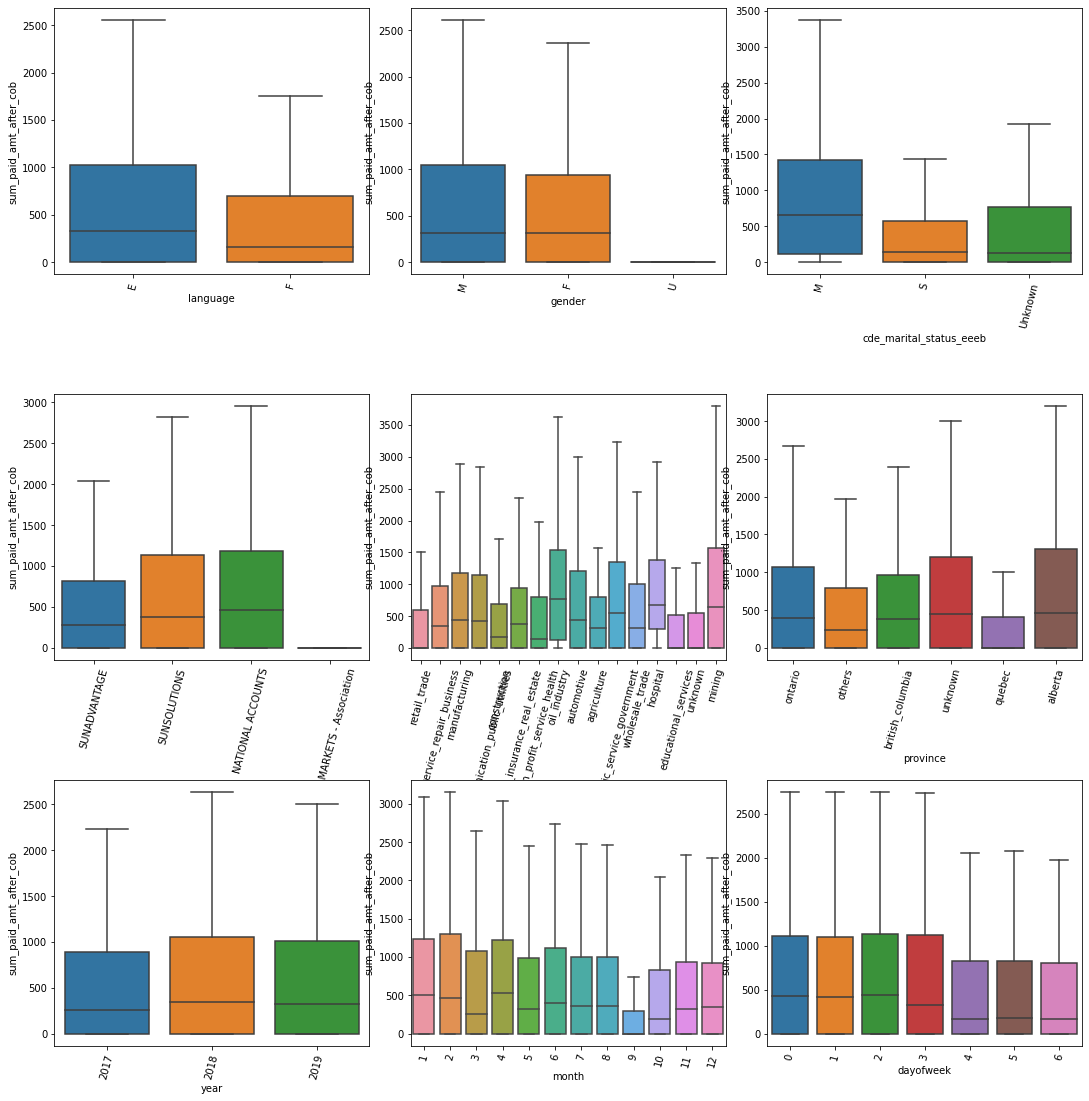

In [24]:
fig, axs = plt.subplots(3, 3, figsize = [15,15])
fig.tight_layout() 
fig.subplots_adjust(hspace=.45)  
for i, feature in enumerate(plotting_df.columns[:-1]):
    ax=axs[i//3,i%3]
    sns.boxplot(x = feature, y = target_column, data=plotting_df, showfliers=False, ax=ax)
    ax.tick_params(axis='x', rotation=75)

## Feature Engineering

In [25]:
def process_dummies(df):
    """Get a dataframe and convert all columns to dummy variables with proper names"""
    df_out = pd.DataFrame({})
    for col in df.columns:
        dummied =pd.get_dummies(df[col], drop_first = True)
        dummied.columns = [f"{col}_{dcol}" for dcol in dummied.columns]
        if len(df_out) == 0:
            df_out = dummied
        else:
            df_out = pd.concat([df_out, dummied], axis = 1)
    return df_out

In [26]:
def process_numeric(df, col: str = None):
    """Scale numerical dara to [0,1] interval"""
    df_out = df.copy()
    if col:
        return df_out[col].transform(lambda x: (x - x.min())/(x.max() - x.min()))
    else:
        for col in df.columns:
            if df[col].sum() > 0:
                df_out[col] = process_numeric(df, col)
    return df_out

In [27]:
categorical_data['year'] = categorical_data['pol_renewal_dt'].dt.year
categorical_data['month'] = categorical_data['pol_renewal_dt'].dt.month
categorical_data['dayofweek'] = categorical_data['pol_renewal_dt'].dt.dayofweek
categorical_data = categorical_data.drop(columns=['pol_renewal_dt'])

processed_data = pd.concat([
    process_numeric(numerical_data.drop(columns=[target_column]).fillna(0)),
    process_dummies(categorical_data),
],
axis = 1)

In [28]:
process_dummies(categorical_data).corr() # #.isnull().sum().rename('cnt').to_frame().query('cnt > 0')

,language_F,gender_M,gender_U,cde_marital_status_eeeb_S,cde_marital_status_eeeb_Unknown,MARKET_SEGMENT_ADJ_SPONSORED MARKETS - Association,MARKET_SEGMENT_ADJ_SUNADVANTAGE,MARKET_SEGMENT_ADJ_SUNSOLUTIONS,industry_automotive,industry_construction,...,month_9,month_10,month_11,month_12,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
language_F,1.000000,0.028942,-0.010030,0.046672,-0.038378,-0.095240,-0.026929,-0.023443,-0.011478,-0.031813,...,-0.099665,0.047651,-0.006475,-0.006768,0.058602,0.010686,0.004076,-0.039255,-0.029387,-0.041856
gender_M,0.028942,1.000000,-0.038111,-0.032889,-0.062162,-0.050198,0.035537,-0.001359,0.085568,0.065225,...,-0.033364,0.018861,-0.001505,-0.020184,0.027386,0.003623,0.020484,-0.001562,-0.029175,-0.036767
gender_U,-0.010030,-0.038111,1.000000,-0.015188,0.035889,0.071380,-0.013604,-0.020799,-0.006175,-0.005497,...,0.054463,0.006811,-0.006928,-0.007494,-0.007675,-0.007709,-0.010105,0.028786,-0.003316,0.006125
cde_marital_status_eeeb_S,0.046672,-0.032889,-0.015188,1.000000,-0.423198,-0.154309,0.107120,0.101519,-0.002879,0.038533,...,-0.119079,0.094448,0.059512,0.028786,0.003102,0.036342,0.052977,0.003482,-0.053303,-0.012069
cde_marital_status_eeeb_Unknown,-0.038378,-0.062162,0.035889,-0.423198,1.000000,0.373166,-0.214958,-0.275109,-0.015800,-0.062047,...,0.264854,-0.135827,-0.131033,-0.029768,-0.010626,-0.087347,-0.124544,0.025000,0.088081,0.041299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dayofweek_2,0.010686,0.003623,-0.007709,0.036342,-0.087347,-0.081017,0.073072,0.027791,0.002791,0.027022,...,-0.103687,-0.059123,0.247687,-0.051299,-0.115979,1.000000,-0.069168,-0.094076,-0.094982,-0.098761
dayofweek_3,0.004076,0.020484,-0.010105,0.052977,-0.124544,-0.106193,0.093836,0.049005,0.076882,0.058552,...,-0.135906,-0.077495,0.184813,-0.067240,-0.152019,-0.069168,1.000000,-0.123309,-0.124497,-0.129450
dayofweek_4,-0.039255,-0.001562,0.028786,0.003482,0.025000,0.194185,0.045913,0.009673,0.022770,-0.011212,...,0.242889,-0.105401,0.126069,0.128057,-0.206761,-0.094076,-0.123309,1.000000,-0.169329,-0.176065
dayofweek_5,-0.029387,-0.029175,-0.003316,-0.053303,0.088081,0.174694,-0.004915,-0.023022,0.005466,0.012175,...,0.228764,-0.106416,-0.085357,0.125686,-0.208754,-0.094982,-0.124497,-0.169329,1.000000,-0.177762


In [29]:
numerical_data.head()

,days_exposure_dental,num_claims,total_num_serv_lines,sum_paid_amt_after_cob,num_claims_dep,total_num_serv_lines_dep,num_claims_exam,num_claims_scaling,num_claims_crowns,num_claims_restorations,...,ftr_env_avg_household_income,ftr_env_med_household_income,ftr_env_pct_household_1person,ftr_env_pct_household_2person,ftr_env_pct_household_3person,ftr_env_pct_household_4person,ftr_env_pct_household_5person,pol_renewal_yr,ftr_years_since_cert_effective,ftr_age_at_renewal
ee_id,,,,,,,,,,,,,,,,,,,,,
3433_3433,365,0.0,0.0,0.0,0.0,0.0,0,0,0,0,...,98299.48,98645.96,0.213650,0.272997,0.181009,0.148368,0.183976,2018,1.750685,50.750685
3433_38,365,0.0,0.0,0.0,0.0,0.0,0,0,0,0,...,96600.43,85154.40,0.291822,0.483271,0.111524,0.083643,0.029740,2017,5.254795,54.613699
3447_8,366,5.0,16.0,1052.8,4.0,13.0,0,1,0,1,...,121483.06,94643.76,0.568966,0.327586,0.068966,0.034483,0.000000,2019,11.257534,51.739726
3473_9,365,0.0,0.0,0.0,0.0,0.0,0,0,0,0,...,63517.52,60000.00,0.611111,0.314815,0.055556,0.018519,0.000000,2017,9.257534,45.279452
3498_1073,366,2.0,8.0,301.6,1.0,4.0,0,0,0,0,...,89307.86,63042.30,0.217391,0.434783,0.130435,0.173913,0.043478,2019,0.246575,47.646575


In [30]:
target_data = data[target_column].copy()

In [31]:
def neg_adjusted_score(y_true, y_pred):
    y_pred = np.where(y_pred<0, 0, y_pred)
    return round(r2_score(y_true, y_pred)*100,2)

In [32]:
x_train, x_test, y_train, y_test = train_test_split(
    processed_data,
    target_data,
    test_size=0.25,
    shuffle=True,
    random_state=42)
for item in (x_train, x_test, y_train, y_test):
    print(len(item))

6000
2000
6000
2000


In [33]:
lin_reg = LinearRegression()
en_reg = ElasticNet()
xgb_reg = xgb.XGBRegressor()

In [34]:
models = {}
for name, reg in zip(['Linear', 'ElasticNet', 'XGB'], [lin_reg, en_reg, xgb_reg]):
    reg.fit(x_train, y_train)
    train_score = neg_adjusted_score(y_train, reg.predict(x_train))
    test_score = neg_adjusted_score(y_test, reg.predict(x_test))
    print(f"Model {name}: \n in sample score is {train_score} and out-sample score is {test_score}")
    models[name] =[reg, train_score, test_score]

Model Linear: 
 in sample score is 91.35 and out-sample score is 88.66
Model ElasticNet: 
 in sample score is 27.15 and out-sample score is 26.61
Model XGB: 
 in sample score is 99.37 and out-sample score is 83.46


In [35]:
def make_predic_result(model):
    pred_test = model.predict(x_test)
    pred_test = np.where(pred_test<0, 0, pred_test)
    pred_results = pd.DataFrame(
        data=np.array([pred_test, y_test, (y_test-pred_test), np.abs(y_test-pred_test)]).T, 
        columns =['y', 'yhat', 'err', 'abs_err']
    )
    return pred_results

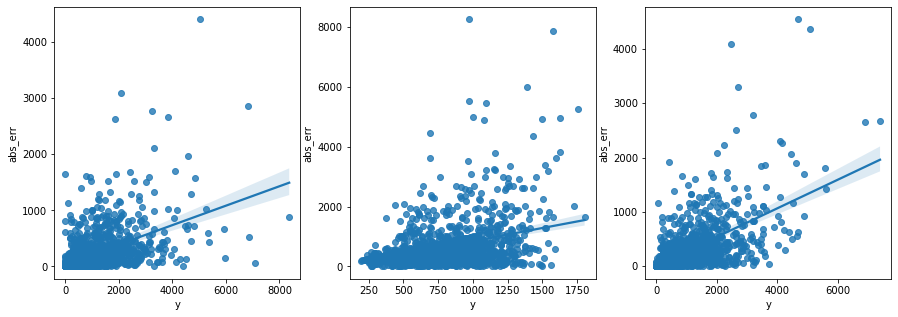

In [36]:
fig, axs = plt.subplots(1, 3, figsize = [15,5])
for i, model in enumerate(['Linear', 'ElasticNet', 'XGB']):
    pred_results = make_predic_result(models[model][0])
    #plt.scatter(x=pred_results['y'], y = pred_results['err'], ax = axs[i])
    #pred_results.plot(x='y', y='abs_err', kind='scatter', ax = axs[i])
    sns.regplot(x='y', y='abs_err', data=pred_results, ax = axs[i])

<AxesSubplot:>

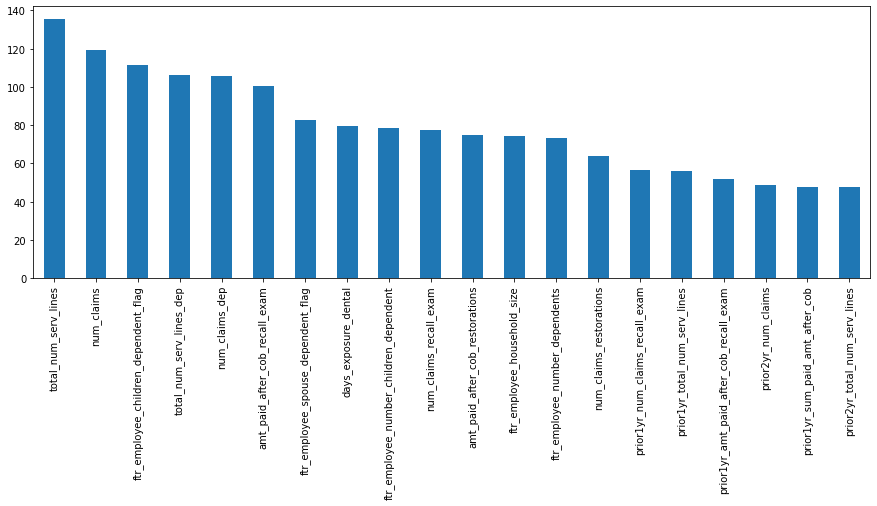

In [37]:
fig, axs = plt.subplots(1, 1, figsize = [15,5])
feature_importance = pd.DataFrame(data=models['ElasticNet'][0].coef_, index = processed_data.columns, columns=['importance'])
feature_importance['abs_importance'] = np.abs(feature_importance['importance'])
feature_importance.sort_values('abs_importance', ascending=False)['importance'].iloc[:20].plot(kind='bar')

In [38]:
xgbr = xgb.XGBRegressor(
    eval_metric = 'rmse',
    nthread = 4,
    eta = 0.1,
    max_depth = 5,
    subsample = 0.5,
    )
parameters = {
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.3, 0.7, 1.0],
}
reg = RandomizedSearchCV(xgbr, parameters, n_jobs=1, cv=3)
reg.fit(x_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, eta=0.1,
                                          eval_metric='rmse', gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=5,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          nthrea

In [39]:
train_score = neg_adjusted_score(y_train, reg.predict(x_train))
test_score = neg_adjusted_score(y_test, reg.predict(x_test))
print(f"Model {name}: \n in sample score is {train_score} and out-sample score is {test_score}")

Model XGB: 
 in sample score is 95.15 and out-sample score is 85.54


## Conclusion

1. There is an omitted variable problem (errors are not independent of y)
2. There is a heterogeneity problem
3. We are possibly overfitting the model
4. XGBoost might potentially perform better than linear models but more hyperparameter tuning is required ti make sure it is nor overfitting